<a href="https://colab.research.google.com/github/sreent/dense-neural-networks/blob/main/codes/ASL%20Sign%20Language%20-%20Image%20Classification%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Defining the problem and assembling a dataset

- Kaggle ASL Alphabet Dataset
  - https://www.kaggle.com/datasets/grassknoted/asl-alphabet
- Multi-Class Classification Problem

 ## Choosing a measure of success

- Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [9]:
# mount gdrive, required for downloaded dataset
import os
from google.colab import drive
drive.mount("/content/drive")

!mkdir -p /content/drive/MyDrive/Neural\ Networks
!mkdir -p /content/drive/MyDrive/Neural\ Networks/American\ Sign\ Language
!mkdir -p /content/drive/MyDrive/Neural\ Networks/American\ Sign\ Language/data

# URL for our dataset, Tweets.csv
URL = "https://drive.google.com/file/d/1Df0wlpvKUSD12RAYihBI-slI1zbz-Vjj/view?usp=sharing"
DOWNLOAD_FILE_PATH = "https://drive.google.com/uc?export=download&id=" + URL.split("/")[-2]

# install gdown, required for download file from GDrive
!pip -q install gdown==4.6.0
import gdown
gdown.download(DOWNLOAD_FILE_PATH, "/content/drive/MyDrive/Neural Networks/American Sign Language/data/asl.zip", quiet=True)

!unzip -qq /content/drive/MyDrive/Neural\ Networks/American\ Sign\ Language/data/asl.zip -d /content/drive/MyDrive/Neural\ Networks/American\ Sign\ Language/data
!rm /content/drive/MyDrive/Neural\ Networks/American\ Sign\ Language/data/asl.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!ls /content/drive/MyDrive/Neural\ Networks/American\ Sign\ Language/data/asl

A  B  C


In [33]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
from skimage.color import rgb2gray

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import F1Score, AUC

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [14]:
def get_image(file, size=(32, 32), gray=True) :
    img = Image.open(file_path)

    img = img.resize(size, Image.ANTIALIAS)

    if gray :
        img = rgb2gray(img)

    return np.array(img)

In [15]:
DATASET = "/content/drive/MyDrive/Neural Networks/American Sign Language/data/asl"
IMAGE_SIZE = (32, 32)
SAMPLE_SIZE = 3000

images, labels = [], []
for folder in os.listdir(DATASET) :
    for file in os.listdir(DATASET + '/' + folder)[:SAMPLE_SIZE] :
        file_path = DATASET + '/' + folder + '/' + file

        image = get_image(file_path, size=IMAGE_SIZE, gray=True)
        images.append( image )

        labels.append(folder)

X = np.array(images)
labels = np.array(labels)

In [16]:
label_encoder = LabelEncoder()
label_encoder.fit(labels)

y = to_categorical(label_encoder.transform(labels))

In [18]:
TEST_SIZE = 0.15

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=TEST_SIZE, stratify=y,
                                        shuffle=True, random_state=SEED)

In [19]:
# normalise pixels from [0, 255] to [0, 1]
X_train, X_test = X_train/255, X_test/255

In [20]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [30]:
len(labels[labels=='A']), len(labels[labels=='B']), len(labels[labels=='C'])

(3000, 3000, 3000)

In [31]:
naive_baseline = len(labels[labels=='A']) / len(labels)

naive_baseline

0.3333333333333333

In [44]:
INPUT_DIMENSION = (32, 32, 1)
OUTPUT_CLASSES = 3

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'categorical_crossentropy'
METRICS = ['categorical_accuracy']

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [56]:
baseline = Sequential(
    [
        Flatten(input_shape=INPUT_DIMENSION, name="flatten"),
        Dense(OUTPUT_CLASSES, activation='softmax', name="output")
    ],
    name="baseline"
)

baseline.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 output (Dense)              (None, 3)                 3075      
                                                                 
Total params: 3075 (12.01 KB)
Trainable params: 3075 (12.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
learning_rate = 0.1
batch_size = 64

EPOCHS = 100

In [58]:
baseline.compile(optimizer=RMSprop(learning_rate=learning_rate),
                 loss=LOSS_FUNC, metrics=METRICS)

In [59]:
baseline_history = baseline.fit(X_train, y_train,
                                batch_size=batch_size, epochs=EPOCHS,
                                validation_data=(X_val, y_val),
                                callbacks=[EARLY_STOP],
                                verbose=0)

In [60]:
baseline_scores = baseline.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baseline_scores[0], naive_baseline))

Accuracy (Validation): 0.74 (Naive Baseline=0.33)


In [61]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)

    plt.plot(epochs, loss, 'b.', label=monitor)
    plt.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

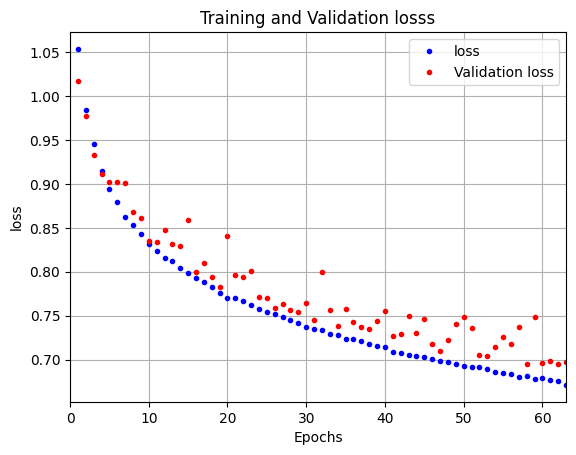

In [62]:
plot_training_history(baseline_history, monitor='loss')

 ## Scaling up: developing a model that overfits

In [135]:
overfit = Sequential(
    [
        Flatten(input_shape=INPUT_DIMENSION, name="flatten"),
        Dense(4, activation="relu", name="hidden"),
        Dense(OUTPUT_CLASSES, activation="softmax", name="output")
    ],
    name="overfit"
)

overfit.summary()

Model: "overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 hidden (Dense)              (None, 4)                 4100      
                                                                 
 output (Dense)              (None, 3)                 15        
                                                                 
Total params: 4115 (16.07 KB)
Trainable params: 4115 (16.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [136]:
learning_rate = 0.01

overfit.compile(optimizer=RMSprop(learning_rate=learning_rate),
                loss=LOSS_FUNC, metrics=METRICS)

In [137]:
EPOCHS = 100
batch_size=512

overfit_history = overfit.fit(X_train, y_train,
                              batch_size=batch_size, epochs=EPOCHS,
                              validation_data=(X_val, y_val),
                              callbacks=[],
                              verbose=0)

In [138]:
overfit_scores = overfit.evaluate(X_val, y_val, verbose=0)[1:]

print('Accuracy (Validation): {:.2f} (Naive Baseline = {:.2f})'.format(overfit_scores[0], naive_baseline))

Accuracy (Validation): 0.61 (Naive Baseline = 0.33)


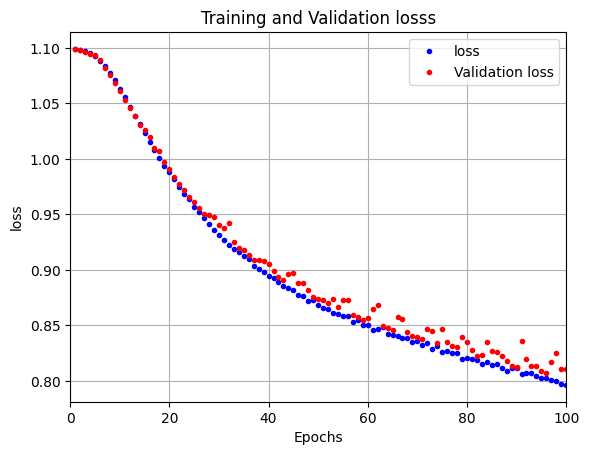

In [139]:
plot_training_history(overfit_history, monitor='loss')